---
# <span style="color:blue">**Tests on different mutliclass classification models**</span>
---

In this notebook, the balanced accuracy and the confusion matrices from the following models is compared in order to have a reference and to choose two of them that can be tuned later. In addition, since some classifiers need the features to be scaled, the MinMaxScaler is used for all of them, even if we know from the previous tests that for the Random Forest classifier there is no need for scaling the features. The scaler has been set to the pipeline by default, as the purpose of these tests is just to have an idea for the performance of different classifiers. 

Models:
1. Baseline (Dummy Classifier with uniform strategy)
2. Gaussian Naive Bayes            
3. KNeighbors Classifier
4. Random Forest Classifier
5. Support Vector Classifier (with linear and rbf kernel)
6. LogisticRegression (one-vs-rest and multinomial)
7. RidgeClassifier


The dataset is initially split into 70-30 for training and testing. Consecutively, the training set is split into 60-40 over 10 different random states for training and validation. Here, the test set is not used. 

---

In [1]:
import os
import pandas as pd
import numpy as np
import utils.preprocess as pre
import utils.testing as testing
import utils.modeling as md

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
### **Load data and split for training, validation and testing**
---

In [2]:
from sklearn.model_selection import train_test_split

# Read reduced data with corrected labels
data_df = pd.read_csv(os.path.join('data', 'ioT_data_reduced_labels_corrected.csv'))


# Split data to X, y
X = data_df.drop(['label', 'detailed_label'], axis=1)
y = data_df['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4,
                                       'PartOfAVerticalPortScan':5
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print('Train size:', X_tr.shape[0])
print('Test size:', X_te.shape[0])

Train size: 141681
Test size: 60721


---
### **1. Baseline**
---

In [3]:
baseline_results = md.fit_baseline(X_tr, y_tr, strategy='uniform')

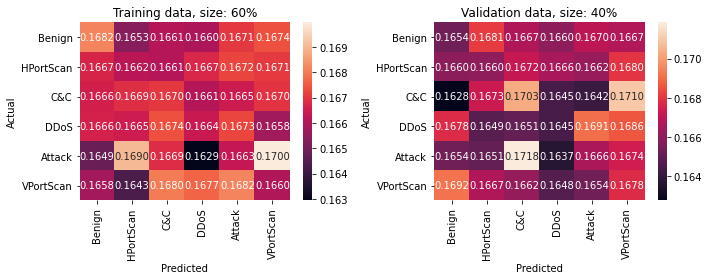

,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std,acc_tr_mean,acc_tr_std,acc_val_mean,acc_val_std
0,0.203153,0.001286,0.202967,0.001917,0.166682,0.002138,0.166763,0.002483


In [4]:
baseline_results_avg = md.average_results(baseline_results)

> The dummy classifier with the uniform strategy performs poorly as expected. The balanced accuracy is ~17% for both training and validation sets.

---
### **2. Run several models for testing**
---

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


def run_models():
    
    # Initialize a dictionary
    ls_models  = ['GaussianNB', 'KNeighborsClassifier', 'RandomForestClassifier', 'LinearSVC', 
                  'SVC', 'LogisticRegression_OvR', 'LogisticRegression_softmax', 'RidgeClassifier']

    ls_empty = [0]*len(ls_models)              

    scores = ({'model': ls_models, 
              'tr_balanced_accuracy_mean': ls_empty,
              'tr_balanced_accuracy_std': ls_empty,
              'val_balanced_accuracy_mean': ls_empty,
              'val_balanced_accuracy_std': ls_empty,              
              })

    scores = pd.DataFrame(scores).set_index('model')



    # Define some models to check
    models = {'GaussianNB': GaussianNB(),
              'KNeighborsClassifier' : KNeighborsClassifier(),
              'RandomForestClassifier' : RandomForestClassifier(n_estimators=10, random_state=0, class_weight='balanced_subsample'),
              'LinearSVC':  LinearSVC(random_state=0, class_weight='balanced'),
              'SVC': SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced'),
              'LogisticRegression_OvR' : LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', class_weight='balanced'),
              'LogisticRegression_softmax': LogisticRegression(random_state=0, multi_class='multinomial', solver='sag', class_weight='balanced'),
              'RidgeClassifier': RidgeClassifier(random_state=0, class_weight='balanced')
             }

    
    # Loop on models
    for (name, model) in models.items():
        
        print('Model:', name)


        # Define the pipeline
        pipe = Pipeline([('recover_nulls', pre.RecoverNansPreprocessor()),
                         ('cleaning_preprocessor', pre.CleaningPreprocessor()), 
                         ('categorical_preprocessor', pre.CategoricalPreprocessor(cols_to_dummies = ['protocol', 'conn_state', 'history'])),
                         ('ip_encoding', pre.IPEncodingPreprocessor(ip_to_octets = True)),
                         ('ft', SelectKBest(k=17)),
                         ('scaler', MinMaxScaler()),                         
                         ('clf', model)

        ])               
        
        # Fit model
        results = md.fit_pipe_single_splitting(X_tr, y_tr, pipe)
        
        # Average results
        results_avg = md.average_results_single_splitting(results)
        
        # Save averaged results into a csv file
        results_avg.to_csv(os.path.join('results', 'results_avg_'+ name + '.csv'), index=False)  
        
        # Save averaged results to scores dictionary
        scores.loc[name, 'tr_balanced_accuracy_mean'] = results_avg['acc_tr_mean'].iloc[0]
        scores.loc[name, 'tr_balanced_accuracy_std'] = results_avg['acc_tr_std'].iloc[0]
        scores.loc[name, 'val_balanced_accuracy_mean'] = results_avg['acc_val_mean'].iloc[0]
        scores.loc[name, 'val_balanced_accuracy_std'] = results_avg['acc_val_std'].iloc[0]        
            
        print('\n')    

    return scores

Model: GaussianNB


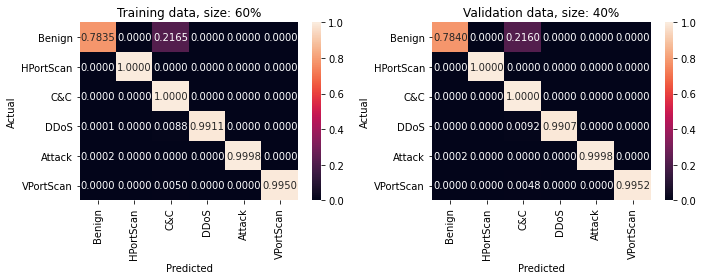

,0
f1_tr_mean,0.976185
f1_tr_std,0.000304
f1_val_mean,0.976230
f1_val_std,0.000455
precision_tr_mean,0.981814
precision_tr_std,0.000173
precision_val_mean,0.981844
precision_val_std,0.000261
recall_tr_mean,0.975886
recall_tr_std,0.000305




Model: KNeighborsClassifier


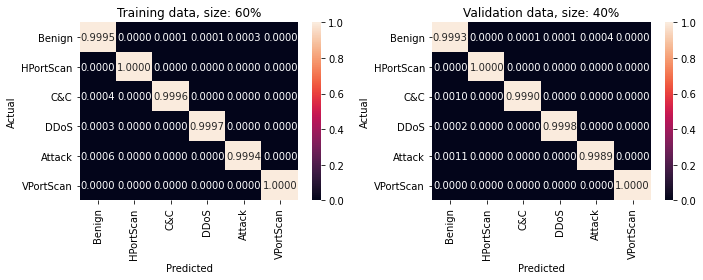

,0
f1_tr_mean,0.999881
f1_tr_std,0.000020
f1_val_mean,0.999815
f1_val_std,0.000055
precision_tr_mean,0.999881
precision_tr_std,0.000020
precision_val_mean,0.999815
precision_val_std,0.000055
recall_tr_mean,0.999881
recall_tr_std,0.000020




Model: RandomForestClassifier


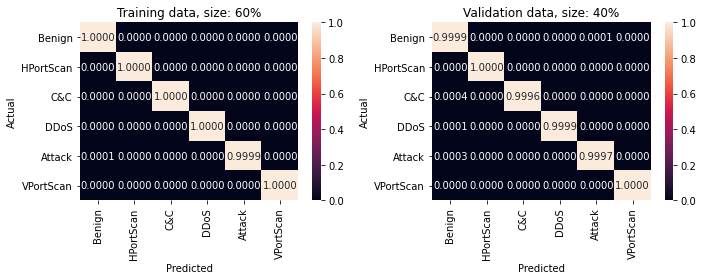

,0
f1_tr_mean,0.999992
f1_tr_std,0.000006
f1_val_mean,0.999944
f1_val_std,0.000030
precision_tr_mean,0.999992
precision_tr_std,0.000006
precision_val_mean,0.999944
precision_val_std,0.000030
recall_tr_mean,0.999992
recall_tr_std,0.000006




Model: LinearSVC


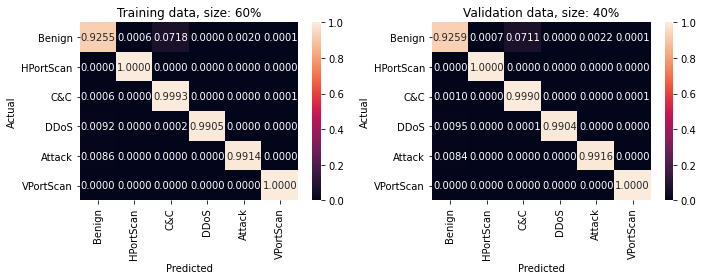

,0
f1_tr_mean,0.991169
f1_tr_std,0.000571
f1_val_mean,0.991186
f1_val_std,0.000967
precision_tr_mean,0.991777
precision_tr_std,0.000476
precision_val_mean,0.991782
precision_val_std,0.000821
recall_tr_mean,0.991134
recall_tr_std,0.000577




Model: SVC


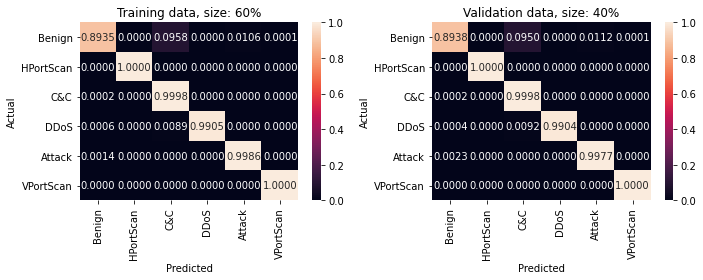

,0
f1_tr_mean,0.988068
f1_tr_std,0.000548
f1_val_mean,0.988053
f1_val_std,0.000345
precision_tr_mean,0.989416
precision_tr_std,0.000458
precision_val_mean,0.989388
precision_val_std,0.000289
recall_tr_mean,0.988009
recall_tr_std,0.000530




Model: LogisticRegression_OvR


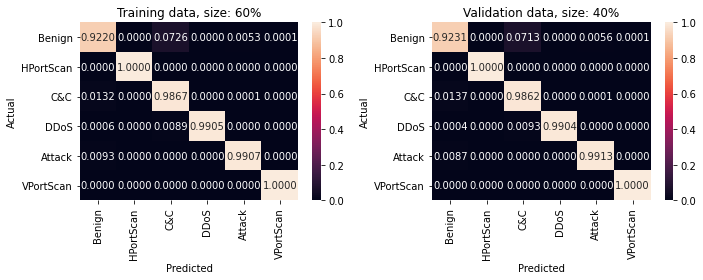

,0
f1_tr_mean,0.989878
f1_tr_std,0.001071
f1_val_mean,0.989956
f1_val_std,0.000967
precision_tr_mean,0.990498
precision_tr_std,0.001230
precision_val_mean,0.990562
precision_val_std,0.001114
recall_tr_mean,0.989821
recall_tr_std,0.001070




Model: LogisticRegression_softmax


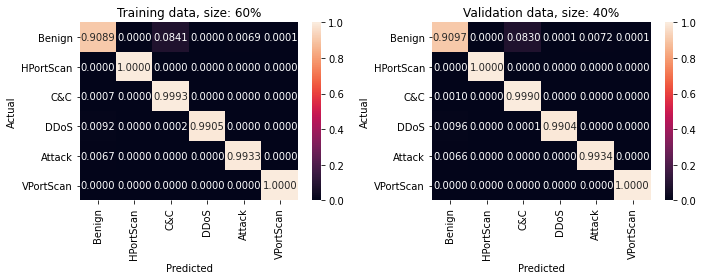

,0
f1_tr_mean,0.989460
f1_tr_std,0.000359
f1_val_mean,0.989522
f1_val_std,0.000212
precision_tr_mean,0.990319
precision_tr_std,0.000320
precision_val_mean,0.990354
precision_val_std,0.000187
recall_tr_mean,0.989430
recall_tr_std,0.000353




Model: RidgeClassifier


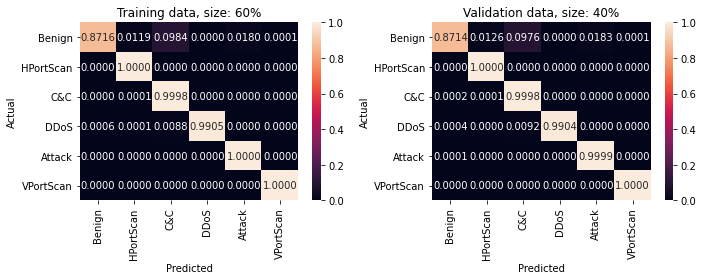

,0
f1_tr_mean,0.985683
f1_tr_std,0.000345
f1_val_mean,0.985631
f1_val_std,0.000357
precision_tr_mean,0.987282
precision_tr_std,0.000277
precision_val_mean,0.987229
precision_val_std,0.000292
recall_tr_mean,0.985735
recall_tr_std,0.000339


In [6]:
scores = run_models()

> For all models, except the kNN and the RandomForest, we see that there are always benign entries misclassified as C&C. In particular, the GaussianNB model has about ~20% of misclassification for those entries while the rest of the models have a bit less than 10% of misclassification for the same class. For the one-vs-rest  Logistic Regression we see that there is in addittion less than 10% of C&C entries misclassified as benign. 

> In contrast, the kNN and RandomForest classifiers have an excellent performance of distinguishing all type of classes with only a very small percentage of missclassification for all the classes except the port scans. 

---
### **3. Comparison of results**
---

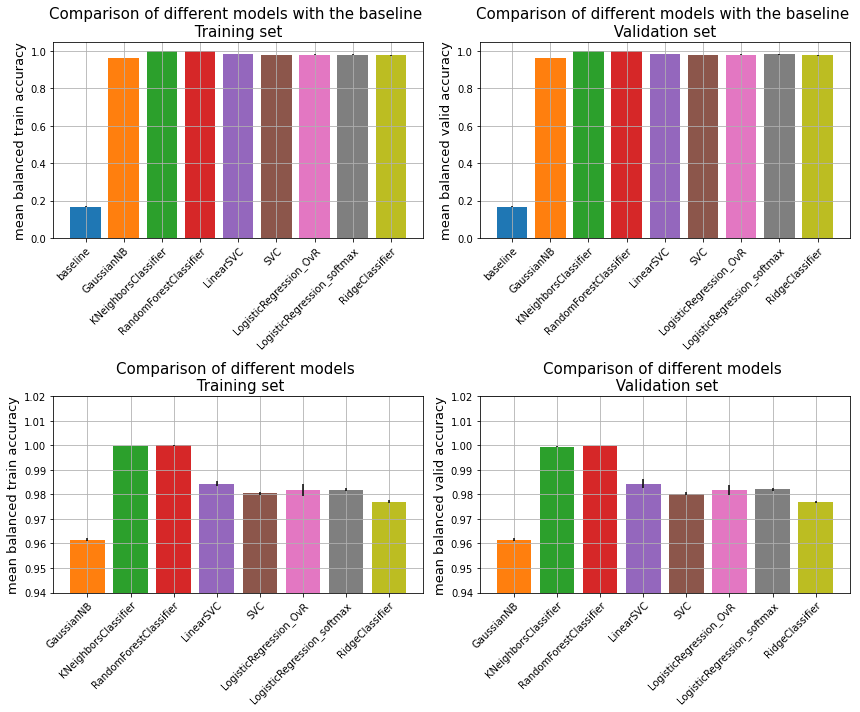

In [7]:
md.compare_classifiers_all(baseline_results_avg, scores, fig_h=12, fig_w=10)

> Overall, the mean balanced accuracy for all the models is >95% with the kNN and Random Forest almost reaching 100% and it is about the same for both training and validation sets. 

In [8]:
# Save results
scores.to_csv(os.path.join('results', 'scores.csv'), index=True)  